This document will walk you through a complete example of using the Pandas library to do data preparation for a neural network model.

Pandas is one of the most popular libraries in the Python world for doing data science. Pandas can help you to pre-process raw data before feeding it to a model.

Before working through this notebook you should familiarize yourself with the basic operations in Pandas. A good way to do this is to read through 
[this online tutorial](https://www.learndatasci.com/tutorials/python-pandas-tutorial-complete-introduction-for-beginners/).

In [1]:
import pandas as pd
import numpy as np

The data set we will work through in this notebook is available on the course web site. Run the code in the cell below to fetch the CSV file with the data you will need.

In [2]:
!wget http://www.lawrence.edu/fast/greggj/CMSC490/short_rides.csv

URL transformed to HTTPS due to an HSTS policy
--2023-09-21 13:17:02--  https://www.lawrence.edu/fast/greggj/CMSC490/short_rides.csv
Resolving www.lawrence.edu (www.lawrence.edu)... 143.44.124.14
Connecting to www.lawrence.edu (www.lawrence.edu)|143.44.124.14|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www7.lawrence.edu/fast/greggj/CMSC490/short_rides.csv [following]
--2023-09-21 13:17:03--  https://www7.lawrence.edu/fast/greggj/CMSC490/short_rides.csv
Resolving www7.lawrence.edu (www7.lawrence.edu)... 143.44.124.14
Connecting to www7.lawrence.edu (www7.lawrence.edu)|143.44.124.14|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.lawrence.edu/fast/greggj/CMSC490/short_rides.csv [following]
--2023-09-21 13:17:03--  https://www2.lawrence.edu/fast/greggj/CMSC490/short_rides.csv
Resolving www2.lawrence.edu (www2.lawrence.edu)... 143.44.124.14
Connecting to www2.lawrence.edu (www2.lawrence.edu)|

The data set is some data that I assembled from Strava data on a series of bike rides I did in 2016 and 2017. All of these rides followed the same route, and on each of these rides a rode the same bicycle. What varied from ride to ride were mostly the weather conditions: over the course of the year the temperature and the wind conditions would vary quite a bit.

Two other bits of data in the data set include what year the ride took place in and some additional detail on the bike used. The year is relevant because there was a slight change to the route from 2016 to 2017, and also I slow down a little bit from year to year as I get older. The data set also contains some information about the
bike I used. I used the same bike for all of these rides, but I have two different sets of wheels that I use on the bike. In the spring and fall I use a heavier and 
more puncture resistant wheel set, while in the summer I use a lighter and faster set of wheels.

In this study we are going to look at the average speed for a bike ride as a function of all of the factors that may affect the outcome.

We start by importing our data from the CSV file. This gets loaded into a Pandas dataframe. The Pandas head() command shows the first few rows in the data frame.

In [3]:
df = pd.read_csv('short_rides.csv')
df.head()

year  wheel      speed  temp  wind    dir
0  2016      1  15.998098  64.0   5.0    NaN
1  2016      0  16.800493  71.0  11.0  170.0
2  2016      0  16.919170  65.0   7.0   95.0
3  2016      0  16.620407  77.0   7.0  120.0
4  2016      0  16.583063  77.0   3.0  220.0

Taking a look at the full data set, the first thing we want to watch out for is missing data values. The 'dir' column, which represents wind direction, has a number of NaN entries. The reason for this is that sometimes when the wind speed drops too low the weather service will refuse to report a wind direction.

One common strategy for fixing these kinds of missing values is to replace the NaN values in a column with the mean value for the variable in that column. First we compute the mean for the 'dir' column.

In [4]:
df['dir'].mean()

184.20212765957447

The pandas fillna method allows us to replace NaN values in a column with values of our choice. In this case, we simply replace all of the NaNs in the 'dir' column with the mean wind direction of 184.

In [5]:
df['dir'] = df['dir'].fillna(value=184)
df.corr()

year     wheel     speed      temp      wind       dir
year   1.000000 -0.076339 -0.277386 -0.131213  0.187193  0.104080
wheel -0.076339  1.000000 -0.699100 -0.708325 -0.102983  0.174093
speed -0.277386 -0.699100  1.000000  0.709205  0.002943 -0.235181
temp  -0.131213 -0.708325  0.709205  1.000000  0.018917 -0.187772
wind   0.187193 -0.102983  0.002943  0.018917  1.000000  0.251351
dir    0.104080  0.174093 -0.235181 -0.187772  0.251351  1.000000

After our first round of data cleaning, the next thing to examine is the correlation matrix for the data set. The correlation matrix can give us a sense for which features are most strongly correlated with the output value. In this example the output value we are trying to explain is the speed. Looking at the row for speed in the correlation matrix, we see that most of the other features are correlated with the speed.

The one surprise here is the correlation between speed and wind speed: that correlation is almost 0, which does not make any sense.

It turns out that the problem here is the way that the data set represents the wind. Wind is represented here as a combination of wind speed ('wind') and wind direction ('dir'). This is problematic for two reasons. The first is the lack of correlation between the wind speed and the speed of travel. The second is that although wind direction is likely to have an impact on speed, that relation may well be non-linear. This is because wind direction is represented as an angle measured clockwise from north.

The fix for both of these problems is to switch to a more appropriate representation for wind. Wind is a vector, and the most natural way to represent vectors is via a list of vector components, not a combination of a vector length and a vector direction. The code below uses the 'wind' and 'dir' columns to construct two new components, 's' and 'w', which decompose the wind vector into southerly and westerly components. After converting the vector representation we can then drop the original 'wind' and 'dir' columns.

One final bit of data cleaning to do here is to transform the year column from values of 2016 or 2017 into 0, 1 values.

In [6]:
df['s'] = df['wind']*np.cos(((df['dir']-180)/180)*np.pi)
df['w'] = df['wind']*np.cos(((df['dir']-270)/180)*np.pi)
df['year'] = df['year']-2016
df = df.drop(['wind','dir'],axis=1).dropna()
df.corr()

year     wheel     speed      temp         s         w
year   1.000000 -0.099840 -0.264604 -0.131213  0.095990  0.190441
wheel -0.099840  1.000000 -0.688161 -0.708325 -0.269389  0.099353
speed -0.264604 -0.688161  1.000000  0.709205  0.224236 -0.213081
temp  -0.131213 -0.708325  0.709205  1.000000  0.389297 -0.040870
s      0.095990 -0.269389  0.224236  0.389297  1.000000  0.021641
w      0.190441  0.099353 -0.213081 -0.040870  0.021641  1.000000

The correlation matrix for the data set after the wind vector fix looks a lot more reasonable. There is now a noticable correlation between wind and speed, as you would expect.

We are now ready to start constructing and training a model. To give us a baseline model to compare an eventual neural network model against I am going to use the sci-kit-learn package to construct a simple machine learning model first.

The first step is to split our data set into a training set, which will be used to train the model, and a test set, which will be used to evaluate the model.

The sci-kit-learn train_test_split function does the job nicely, randomly splitting the original data set into a training set and a test set. A widely used convention in data science is to set aside 20% of the original data set as a test set, so that is what we do here.

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df,test_size=0.2,random_state=42)

The model we will use for this example is one of the simplest models available, a multi-linear regression model.

The code below loads the model, and fits it to the training set X and y values.

In [5]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
X = train_set[['year','wheel','temp','s','w']]
y = train_set['speed']
lin_reg.fit(X,y)

LinearRegression()

Once the model has been trained by fitting it to the training data, we can use the model to make predictions. We feed the model the test data set X values and then compare the predictions produced by the model with y values from the test set.

In [6]:
predictions = lin_reg.predict(test_set[['year','wheel','temp','s','w']])
predictions - test_set['speed']

30    0.664158
43    0.160004
29   -0.166340
47   -0.428257
27   -0.007010
40    0.697200
14   -0.821402
22   -0.621427
5     0.063666
28   -0.370111
Name: speed, dtype: float64

As you can see, most of these predictions are reasonably good.

A standard metric to apply to a set of predictions is the mean square error. As usual, sci-kit-learn has evaluation functions ready to help us compute this metric.

In [7]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predictions,test_set['speed'])
mse

0.23658250196854227

One last thing to look at in our model is the model coefficients. These coefficients can give us a sense for the impact of each one of the input features.

The coefficients here tell me that in going from 2016 to 2017 my average speed dropped by 0.3 mph. This models the impact of the installation of the roundabout on my route, which forced me to stop at an intersection I would typically zip through without stopping. The coefficients also say that putting on the heavy winter wheel causes my average speed to drop by about 0.6 mph: this lines up pretty well with my own experience. Another interesting observation here concerns the wind speed. The westerly component of the wind speed has an impact about six times larger than the southerly component. This makes perfect sense, since most the route lines up in an east-west direction, with the segment where I am travelling to the west more exposed to the wind than the segment where I am travelling to the east.

In [8]:
lin_reg.intercept_,lin_reg.coef_

(15.593571424281194,
 array([-2.85780789e-01, -7.58538983e-01,  1.47548761e-02,  4.81419590e-03,
        -3.48648341e-04]))

One last experiment before we conclude this first pass through the data. The mse we computed above is based on a single train/test split of the data. Like all experiments that depend on random samples, this mse value is likely to fluctuate as we do different splits. One way to model this effect is to perform a cross validation.

To do a cross validation we start by randomizing the data set. We then split the data set into N equal sized folds and then run N experiments. In each experiment we set aside one of the folds as a test set, train the model on the remaining N-1 folds, and then compute an rms error for the test set. Finally, we average together the rms errors for the N experiments to produce an average rms error. This average error gives us a better feel for the actual model error for our model.

As always, sci-kit-learn has a handy function available to perform cross validations, cross_val_score. Before calling this function I have to first shuffle the full data set. The key to doing the shuffling is to to use the numpy permutation function to make a randomly permuted list of the indices and then pass that list of shuffled indices to the pandas iloc function to shuffle the rows in the original data set.

In [10]:
from sklearn.model_selection import cross_val_score
shuffled_indices = np.random.permutation(len(df))
shuffled_data = df.iloc[shuffled_indices]
full_X = shuffled_data[['year','wheel','temp','s','w']]
full_Y = shuffled_data['speed']
scores = cross_val_score(lin_reg,full_X,full_Y,scoring='neg_mean_squared_error',cv=5)
scores

array([-0.36602975, -0.14647831, -0.10125056, -0.14462003, -0.150603  ])

The scores for the five folds do vary somewhat, which is to be expected. Taking the average of the errors for the five folds will give us a better sense for the average error we can expect from this model.

In [12]:
np.sqrt(-scores.mean())

0.42637580855203794

This tells us that the model we constructed here is able to predict my speed on the route accurate to about 0.4 mph. This is a pretty decent final result.

Now want to construct a simple neural network model for this same data set.

The first thing I am going to do is to follow a slightly different procedure to construct a training set and a test set. We will use the Pandas sample() method to shuffle the rows in the dataframe, and then split off the last 11 rows for use in a test set.

In [7]:
df = df.sample(frac=1)
df.head()

year  wheel      speed  temp             s          w
47     1      0  16.577971  55.0  6.062178e+00  -3.500000
32     1      0  16.852150  66.0  5.985384e+00   0.418539
50     1      1  15.388298  37.0  4.898587e-16   8.000000
45     1      0  15.833345  70.0  5.282728e+00  11.328847
38     1      0  16.395075  74.0  5.196152e+00   3.000000

I will use the Pandas to_numpy() method to convert parts of the dataframe to numpy arrays, because keras works best with numpy arrays as its inputs.

In [8]:
input = df.drop(['speed'],axis=1).to_numpy()
output = df['speed'].to_numpy()
print(input.shape)
mean_speed = output.mean()
train_data = input[:41,:]
train_targets = output[:41] - mean_speed
test_data = input[41:,:]
test_targets = output[41:] - mean_speed

(52, 5)


Now we are ready to build and train our neural network. We start with a simple network with two hidden layers.

In [112]:
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(12, activation="relu"),
        layers.Dense(12, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
    return model

In [115]:
from tensorflow import keras

model = build_model()
history = model.fit(train_data, train_targets,
              epochs=80, batch_size=41,validation_data=(test_data, test_targets))

Epoch 1/80


1/1 [==============================] - 1s 692ms/step - loss: 0.7459 - mae: 0.7059 - val_loss: 49.1181 - val_mae: 6.6360
Epoch 2/80
1/1 [==============================] - 0s 12ms/step - loss: 0.7248 - mae: 0.6959 - val_loss: 27.1337 - val_mae: 4.8620
Epoch 3/80
1/1 [==============================] - 0s 12ms/step - loss: 0.7042 - mae: 0.6861 - val_loss: 18.2167 - val_mae: 3.9391
Epoch 4/80
1/1 [==============================] - 0s 13ms/step - loss: 0.6843 - mae: 0.6764 - val_loss: 13.3767 - val_mae: 3.3404
Epoch 5/80
1/1 [==============================] - 0s 12ms/step - loss: 0.6649 - mae: 0.6669 - val_loss: 10.3496 - val_mae: 2.9083
Epoch 6/80
1/1 [==============================] - 0s 12ms/step - loss: 0.6461 - mae: 0.6574 - val_loss: 8.3035 - val_mae: 2.5796
Epoch 7/80
1/1 [==============================] - 0s 12ms/step - loss: 0.6279 - mae: 0.6480 - val_loss: 6.8263 - val_mae: 2.3152
Epoch 8/80
1/1 [==============================] - 0s 12ms/step - loss: 0.6102 - mae: 0.6387 - val_loss

This is very promising. The validation mse at the end of training is very much in line with the mse we saw in the earlier model.

We can also produce a plot of the validation loss over time.

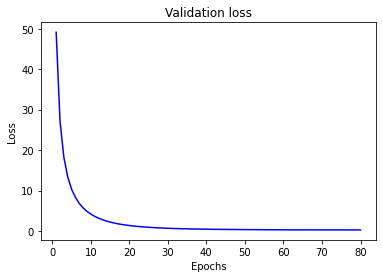

In [116]:
import matplotlib.pyplot as plt
val_loss = history.history["val_loss"]
epochs = range(1, len(val_loss) + 1)
plt.title("Validation loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

We can also look at the differences between the test targets and the predictions from the model.

In [117]:
predictions = model(test_data)
predictions - test_targets.reshape(11,1)

<tf.Tensor: shape=(11, 1), dtype=float32, numpy=
array([[-0.57010746],
       [ 1.1279202 ],
       [-0.705061  ],
       [ 0.36221176],
       [-0.0437212 ],
       [ 0.079593  ],
       [ 0.3533738 ],
       [ 0.36825225],
       [ 0.63397   ],
       [-0.3132585 ],
       [-0.05065578]], dtype=float32)>

These look pretty reasonable.

One final comment - since we normalized the data for this example and we did not normalize the inputs to the regression model above, we have to scale the mse for the neural network model by the standard deviation of the original outputs:

In [118]:
np.sqrt(history.history["val_loss"][-1]*df['speed'].std())

0.41441898152670054

This is comparable to the rms error of the earlier model, which was about 0.4 mph.